In [ ]:
import os
import pandas as pd
s ='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', s)
df = pd.read_csv(s,
header=None,
encoding='utf-8')

df.tail(5)

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


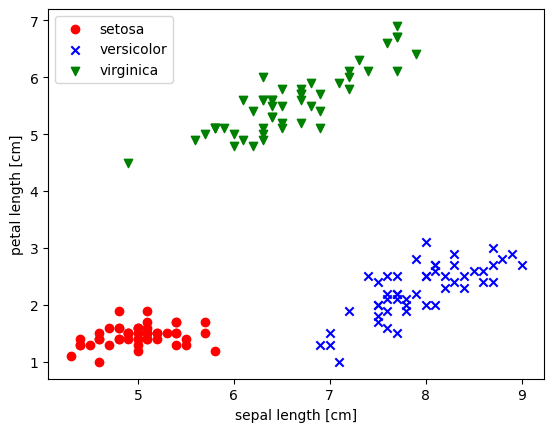

In [ ]:
import numpy as np
names = df.iloc[:, 4].values
y = [0, 0, 0]
y[0] = np.where(names == 'Iris-setosa', 1, -1)
y[1] = np.where(names == 'Iris-versicolor', 1, -1)
y[2] = np.where(names == 'Iris-virginica', 1, -1)


X = df.iloc[:, [0, 2]].values
%matplotlib inline
import matplotlib.pyplot as plt
X[50:100, 0] += 2   # przesunięcie zbioru versicolor w prawo
X[50:100, 1] -= 2   # przesunięcie zbioru versicolor w dół
# problem staje się liniowo separowalny

plt.scatter(X[:50, 0], X[:50, 1],
color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
color='blue', marker='x', label='versicolor')
plt.scatter(X[100:150, 0], X[100:150, 1],
color='green', marker='v', label='virginica')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

In [ ]:
import numpy as np
import random
class Perceptron(object):
  def __init__(self, eta=0.01, n_iter=50, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def fit(self, X, y):
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
    self.errors_ = []
    for _ in range(self.n_iter):
      errors = 0
      for xi, target in zip(X, y):
        update = self.eta * (target - self.predict(xi))
        self.w_[1:] += update * xi
        self.w_[0] += update
        errors += int(update != 0.0)
      self.errors_.append(errors)
    return self
  
  def net_input(self, X):
    return np.dot(X, self.w_[1:]) + self.w_[0]
  
  def predict(self, X):
    return np.where(self.net_input(X) >= 0.0, 1, -1)

  def net_input_weights(self, X, weights):
    return np.dot(X, weights[1:]) + weights[0]
  
  def predict_weights(self, X, weights):
    return self.net_input_weights(X, weights)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class SLP(object):
  def __init__(self, eta=0.01, n_iter=50, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def fit(self, X, y):
    self.errors_ = []
    self.perceptrons_ = []
    for i in range(0, len(y)):
      self.perceptrons_.append(Perceptron(eta=self.eta, n_iter=self.n_iter, random_state=self.random_state))
      self.perceptrons_[i].fit(X, y[i])
      if len(self.errors_) == 0:
        self.errors_ = self.perceptrons_[i].errors_
      else:
        self.errors_ = [sum(j) for j in zip(self.errors_, self.perceptrons_[i].errors_)]

  def predict(self, X):
    self.predictions = [0] * len(self.perceptrons_)
    for i in range(0, len(self.perceptrons_)):
      self.predictions[i] = self.perceptrons_[i].predict(X)
    return self.predictions
  
  def misclassified(self, y, X):
    result = 0
    predictions = self.predict(X)
    predictions = [list(map(lambda x: int(x * (-1)), i)) for i in predictions]
    for i in range(0, len(y)):
      result =  result + (sum(map(lambda x: abs(x) // 2, map(sum, zip(predictions[i], y[i])))))
    return result
  
  def misclassified_weights(self, y, X, weights):
    result = 0
    predictions = self.predict_weights(X, weights)
    predictions = [list(map(lambda x: int(x * (-1)), i)) for i in predictions]
    for i in range(0, len(y)):
      result =  result + (sum(map(lambda x: abs(x) // 2, map(sum, zip(predictions[i], y[i])))))
    return result
  
  def predict_weights(self, X, weights):
    predictions = [0] * len(self.perceptrons_)
    for i in range(0, len(self.perceptrons_)):
      start_weights = i * (1 + X.shape[1])
      end_weights = (i + 1) * (1 + X.shape[1])
      predictions[i] = self.perceptrons_[i].predict_weights(X, weights.values[start_weights:end_weights])
    return predictions


In [ ]:
class Weight:
    def __init__(self, slp, values):
        self.slp = slp
        self.values = values
        self.errors = 0

    def set_random(self, lower_bound=-100, upper_bound=100):
        for i in range(0, len(self.values)):
            self.values[i] = random.uniform(lower_bound, upper_bound)

    def fit(self, X, y):
        self.errors = self.slp.misclassified_weights(y, X, self)

In [ ]:
class Gen_SLP:
    def __init__(self, slp, max_iter=1000, size=100, lower_bound=-100, upper_bound=100, random_state=49):
        random.seed(random_state)
        self.slp = slp
        self.max_iter = max_iter
        self.size = size
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.random_state = random_state

        self.best_errors = []
        self.avg_errors = []

        self.weights = []

    def sort_weights(self, low, high):
        if low < high:
            pivot = self.weights[high-1]
            i = low
            for x in range(low, high-1):
                if self.weights[x].errors <= pivot.errors:
                    (self.weights[i], self.weights[x]) = (self.weights[x], self.weights[i])
                    i = i + 1
 
            (self.weights[i], self.weights[high - 1]) = (self.weights[high - 1], self.weights[i])

            pi = i
 
            self.sort_weights(low, pi)
            self.sort_weights(pi + 1, high)

    def next_generation(self):
        new_weights = []
        for i in range(0, self.size // 10):
            new_weights.append(self.weights[i])

        for i in range(self.size // 10, self.size):
            p1 = 0
            p2 = 0
            while p1 == p2:
                p1 = random.randint(0,49)
                p2 = random.randint(0,49)

            par1 = self.weights[p1]
            par2 = self.weights[p2]

            mutation = Weight(self.slp, [0] * len(self.weights[0].values))
            mutation.set_random(self.lower_bound, self.upper_bound)

            for y in range(0, len(mutation.values)):
                r = random.random()
                if r < 0.45:
                    mutation.values[y] = par1.values[y]
                elif r >= 0.45 and r < 0.90:
                    mutation.values[y] = par2.values[y]
      
            new_weights.append(mutation)
            
        self.weights = new_weights
        return new_weights    

    def append_stats(self):
        self.best_errors.append(self.weights[0].errors)
        self.avg_errors.append(sum([x.errors for x in self.weights]) / self.size)

    def show_stats(self):
        plt.plot(range(0, len(self.best_errors)), self.best_errors, marker='o', label='Najlepszy wynik')
        plt.plot(range(0, len(self.avg_errors)), self.avg_errors, marker='o', label='Średni wynik')
        plt.xlabel('Generacja')
        plt.ylabel('Ilość błędów')
        plt.legend()
        plt.show()

    def fit(self, X, y):
        self.weights = []
        for i in range(0, self.size):
            self.weights.append(Weight(self.slp, [0] * ((1 + X.shape[1]) * len(y))))
            self.weights[i].set_random(self.lower_bound, self.upper_bound)
            self.weights[i].fit(X, y)
        
        self.sort_weights(0, self.size)
        self.append_stats()

        print('Iteracja 1: ')
        print(f'Najlepszy wynik:\n Ilość błędów: {self.best_errors[0]}')
        print(f'Średni wynik:\n Ilość błędów: {self.avg_errors[0]}')
        
        print(self.weights[0].values)

        for i in range(1, self.max_iter):
            self.weights = self.next_generation()
            for x in self.weights:
                x.fit(X, y)
            self.sort_weights(0, self.size)
            self.append_stats()

            if self.best_errors[i] == 0:
                print(f'Iteracja {i}: ')
                print(f'Najlepszy wynik:\n Ilość błędów: {self.best_errors[i]}')
                print(f'Średni wynik:\n Ilość błędów: {self.avg_errors[i]}')
                print(f'Najlepsze wagi: {self.weights[0].values}')
                self.show_stats()
                break

            if (i + 1) % 10 == 0:
                print(f'Iteracja {i + 1}: ')
                print(f'Najlepszy wynik:\n Ilość błędów: {self.best_errors[i]}')
                print(f'Średni wynik:\n Ilość błędów: {self.avg_errors[i]}')
                print(f'Najlepsze wagi: {self.weights[40].values}')



Liczba błędnie sklasyfikowanych próbek: 0


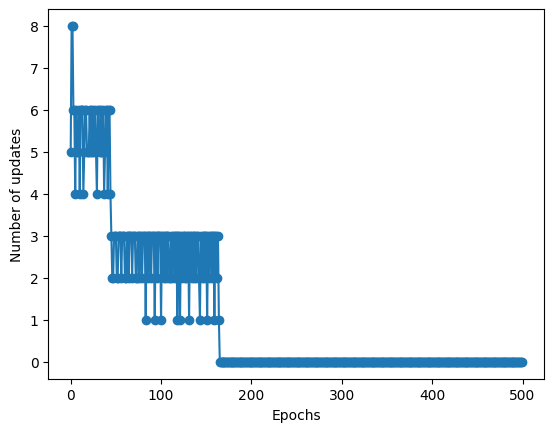

In [ ]:
slp = SLP(eta=0.01, n_iter=500)
slp.fit(X, y)
print(f'Liczba błędnie sklasyfikowanych próbek: {slp.misclassified(y, X)}')
plt.plot(range(0, len(slp.errors_) ), slp.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

Iteracja 1: 
Najlepszy wynik:
 Ilość błędów: 71
Średni wynik:
 Ilość błędów: 641.07
[-0.14073785229176794, 0.2766944970739158, -0.5218983965980935, 0.4714621460773347, 0.14309095890199108, -0.732959092718545, -0.2537604125039654, 0.30855356450524885, -0.31835183717435833]
Iteracja 4: 
Najlepszy wynik:
 Ilość błędów: 0
Średni wynik:
 Ilość błędów: 266.03
Najlepsze wagi: [-0.14073785229176794, 0.1308260666636083, -0.20574248019547103, -0.0452564974181775, 0.14309095890199108, -0.4198991563584469, -0.08733731106435183, 0.025393025826018878, -0.03337586203694243]


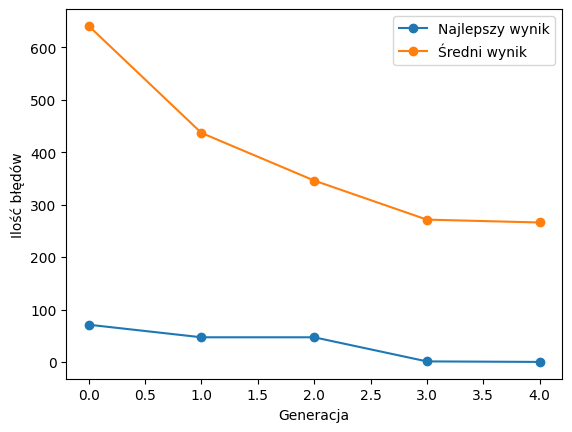

In [ ]:
ga = Gen_SLP(slp, max_iter=1000, lower_bound=-1, upper_bound=1, size=100, random_state=34664)
ga.fit(X, y)